# Word Frequency Distribution

Diachronic word frequencies (time slices aligned with Barbara's code).

In [366]:
#imports
import nltk
from nltk.text import Text, TextCollection
import pandas as pd
from utils.data.readCorpus import NltkCorpusFromDir, NltkCorpusFromList
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"
import os, sys, itertools, re
import numpy as np
###
from nltk.corpus.reader.plaintext import PlaintextCorpusReader, CategorizedPlaintextCorpusReader
from nltk.tokenize.simple import SpaceTokenizer, LineTokenizer

In [367]:
# we'll first define plotting function to facilitate multiplot generation
def build_multiplot(cols, subplot_type, n_items, subplot_titles, **kwargs):
    rows = divmod(n_items, cols)[0] + 1 if divmod(n_items, cols)[1] > 0 else divmod(n_items, cols)[0]
    rows_cols = [ (col, row) for col, row in itertools.product(range(1,rows+1), range(1,cols+1)) ]
    specs =  [ [ {"type": subplot_type} for col in range(1, cols+1) ] for i in range(1, rows+1) ] if subplot_type is not None else None
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=subplot_titles if subplot_titles is not None else None,
        specs = specs,
        **kwargs
    )
    
    return fig, rows_cols

## The corpus

The corpus processing phase follows as close as possible BMG's workflow to keep models compatible. There are 2 exceptions:

- all lemmas are converted to lowercase and
- anomalous lemmas (mostly punctuation) are added to stopword list.

In [368]:
# corpus files
dir_input =  os.path.join("/home/krzys/Kod/lvlt22/BMG/LatinISE_1/")
dir_in = os.path.join(dir_input, "preprocessed_lemmas")
dir_in_words = os.path.join(dir_input, "preprocessed_tokens")
files = os.listdir(os.path.join(dir_in))
files = [f for f in files[:] if "IT" in f]


### Process the metadata
We'll be storing corpus metadata in a data frame.

In [417]:
# metadata (BMG)
metadata_df = pd.read_csv(os.path.join(dir_input, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df.head()
metadata_df["date"] = metadata_df["date"].astype('int') #ensure we're working with integers

In [418]:
first_date = min(metadata_df.date) # BMG
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


In [419]:
last_date = 900 # BMG

Define size of the time intervals:

In [420]:
size_interval = 450 # BMG

So there are

In [421]:
n_intervals = round((last_date-first_date)/size_interval) # BMG
n_intervals

3

time intervals.

Define the time periods and split the corpus:

In [422]:
intervals = [None]*(n_intervals+1) # BMG
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900]


Add a column to the metadata_df for the time interval:

In [423]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18     382
23     399
24     391
37     158
38      49
      ... 
682    382
683    116
684    116
685    116
686    116
Name: date, Length: 235, dtype: int64
2
range(450, 900)
20      524
102     800
104     800
105     800
106     800
       ... 
609     598
634     550
636     550
645     450
1265    533
Name: date, Length: 73, dtype: int64


id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
21      IT-LAT0012   In psalmis Davidis expositio   
22      IT-LAT0014                Adoro te devote   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
21                              Thomas Aquinas: Sanctus  1254   prose   
22                              Thomas Aquinas: Sanctus  1254  poetry   
...                                                 ...   ...     ...   
683                  Tacitus, Publius (Gaius) Cornelius   116   prose   
684                  Tacitus, Publius (Gaius) Cornelius   116   prose   
685                  Tacitus, Publius (Gaius) Cornelius   116   prose   
686                  Tacitus, Publius (Gaius) Cornelius   116   prose   
1265  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

                           file time_interval  
18      lat_0382_IT-LAT0001.txt             0  
19      lat_-009_IT-LAT0537.txt          -450  
20      lat_0524_IT-LAT0011.txt           450  
21      lat_1254_IT-LAT0012.txt                
22      lat_1254_IT-LAT0014.txt                
...                         ...           ...  
683   lat_0116_IT-LAT0534_1.txt             0  
684   lat_0116_IT-LAT0534_2.txt             0  
685   lat_0116_IT-LAT0534_3.txt             0  
686   lat_0116_IT-LAT0534_4.txt             0  
1265    lat_0533_IT-LAT0202.txt           450  

[670 rows x 7 columns]

We'll map time intervals to colors.

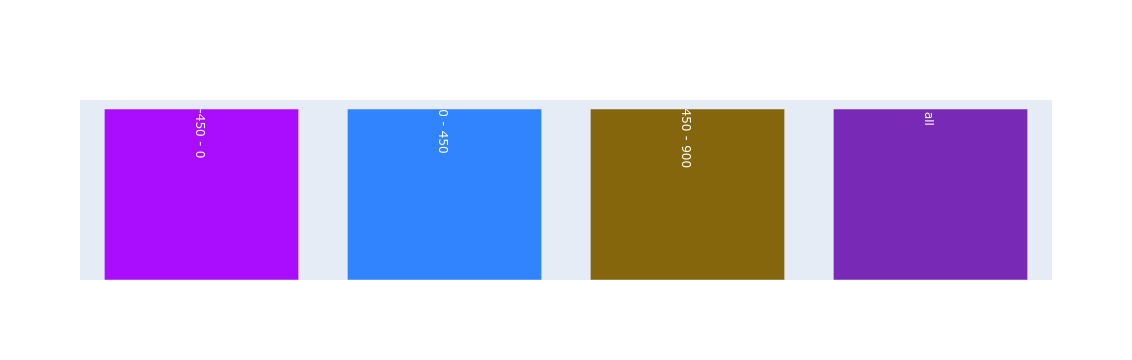

In [424]:
period_labels = intervals_labels + ["all"]
periods2colors = { period : px.colors.qualitative.Alphabet[i] for i, period in enumerate(period_labels)} # for each period we fix a color
fig = go.Figure()
fig.add_trace(go.Bar(
    x = [col for col in periods2colors.keys()],
    y = [0.5 for x in range(0, len(periods2colors)) ],
    text = period_labels
,
    textangle=90,
    marker_color=[col for col in periods2colors.values()]
))
fig.update_layout(showlegend=False, xaxis={'showgrid': False, 'visible': False}, yaxis={'showgrid': False, 'visible': False})

#### Abbreviations

For visualization purposes, we'll add standard ThLL and NGML abbreviations for selected texts.

In [425]:
abbreviations = {"IT-LAT0001_26":"Vlg. Jer.",
                "IT-LAT0001_23":"Vlg. 1 Macc.",
                "IT-LAT0142":"Liv.",
                "IT-LAT0135":"Cic. Balb.",
                "IT-LAT0922_4":"Cic. de orat.",
                "IT-LAT0119":"Cic. rep.",
                "IT-LAT0075":"Cic. Phil.",
                "IT-LAT0135":"Cic. Balb.",
                "IT-LAT0883":"Val. Max.",
                "IT-LAT0201":"Iust.",
                "IT-LAT0121":"Amm.",
                "IT-LAT0907":"P. Diac. H. Rom.",
                "IT-LAT0338":"P. Diac. H. Langob.",
                "IT-LAT0494":" Agnell. Rav. lib. pont.",
                "IT-LAT0783":"Greg. Tur. Franc.",
                "IT-LAT0867":"Cod. Iust.",
                }
abbreviations_df = pd.DataFrame.from_dict(abbreviations, orient="index", columns=["abbr"])
abbreviations_df = abbreviations_df.reset_index().rename(columns={"index":"id"})

In [426]:
metadata_df = metadata_df.merge(abbreviations_df, how="left", on="id").reset_index(drop=True)
metadata_df.head()

id                         title                  creator  date  \
0  IT-LAT0001                       Vulgata               Hieronymus   382   
1  IT-LAT0537                  Ars amatoria    Ovidius Naso, Publius    -9   
2  IT-LAT0011           S. Benedicti Regula     Benedictus Nursianus   524   
3  IT-LAT0012  In psalmis Davidis expositio  Thomas Aquinas: Sanctus  1254   
4  IT-LAT0014               Adoro te devote  Thomas Aquinas: Sanctus  1254   

     type                     file time_interval abbr  
0  poetry  lat_0382_IT-LAT0001.txt             0  NaN  
1  poetry  lat_-009_IT-LAT0537.txt          -450  NaN  
2   prose  lat_0524_IT-LAT0011.txt           450  NaN  
3   prose  lat_1254_IT-LAT0012.txt                NaN  
4  poetry  lat_1254_IT-LAT0014.txt                NaN

### Read in corpus files

First, let's keep only fur further analyses only texts created before the `last_date`.

In [427]:
# define corpus subset
corpus_subset = metadata_df[metadata_df['date'] <= last_date].copy().reset_index(drop=True)
filenames_subset = corpus_subset['file'] # filenames were defined above to get IT files only

In [428]:
# prepare the corpus
punctuation = ['.', ',', '...', ';', ':', '?', '(', ')', '-', '!', '[', ']', '"', "'", '""', '\n']

In [429]:
class NltkCorpusFromDirNew(PlaintextCorpusReader):
    "A subclass of NLTK PlaintextCorpusReader"
    
    word_tokenizer=SpaceTokenizer() # tokenize on whitespace
    sent_tokenizer=LineTokenizer() # assume sentence per line
    
    def __init__(
        self,
        root,
        fileids,
        encoding="utf8",        
        word_tokenizer=word_tokenizer,
        sent_tokenizer=sent_tokenizer,
        tolower=False, punctuation=None
    ):

        PlaintextCorpusReader.__init__(self, root=root, fileids=fileids, encoding=encoding,
                                       word_tokenizer=word_tokenizer,
                                       sent_tokenizer=sent_tokenizer)
        self.tolower = tolower
        self.punctuation = punctuation
        
    def _read_word_block(self, stream):
        words = []
        for i in range(20):  # Read 20 lines at a time.
            if self.punctuation is not None:
                words.extend( [ token.lower() if self.tolower == True else token for token in self._word_tokenizer.tokenize(stream.readline()) if token not in self.punctuation  ])
            else:
                words.extend( [ token.lower() if self.tolower == True else token for token in self._word_tokenizer.tokenize(stream.readline()) ])
        return words

The `latinise` corpus contains lemmatized texts.

In [430]:
#prepare the corpus
latinise = NltkCorpusFromDirNew(root=dir_in, fileids=filenames_subset,
                                punctuation=punctuation, tolower=True)
latinise_docs = []
for fileid in latinise.fileids():
    latinise_docs.append(Text(latinise.words(fileid)))
print("This corpus contains ", len(latinise_docs), " documents.")

This corpus contains  385  documents.


The `latinise_words` corpus contains tokenized texts.

In [431]:
# read in word corpus for token stats
latinise_words = NltkCorpusFromDirNew(root=dir_in_words, fileids=filenames_subset,
                                punctuation=punctuation, tolower=True)
latinise_words_docs = []
for fileid in latinise_words.fileids():
    latinise_words_docs.append(Text(latinise_words.words(fileid)))
print("This corpus contains ", len(latinise_words_docs), " documents.")

This corpus contains  385  documents.


The `metadata_df_subset` will now store metadata for the slimmed down corpus.

In [432]:
metadata_df_subset = corpus_subset
metadata_df_subset.head()

id                title                creator  date    type  \
0  IT-LAT0001              Vulgata             Hieronymus   382  poetry   
1  IT-LAT0537         Ars amatoria  Ovidius Naso, Publius    -9  poetry   
2  IT-LAT0011  S. Benedicti Regula   Benedictus Nursianus   524   prose   
3  IT-LAT0015         Confessiones   Augustinus, Aurelius   399   prose   
4  IT-LAT0016               Regula   Augustinus, Aurelius   391   prose   

                      file time_interval abbr  
0  lat_0382_IT-LAT0001.txt             0  NaN  
1  lat_-009_IT-LAT0537.txt          -450  NaN  
2  lat_0524_IT-LAT0011.txt           450  NaN  
3  lat_0399_IT-LAT0015.txt             0  NaN  
4  lat_0391_IT-LAT0016.txt             0  NaN

Retrieve corpus counts for texts listed in the `metadata_df_subset`.

In [433]:
intervals_labels = [ ' - '.join([str(bin1), str(bin2)]) for bin1, bin2 in zip(intervals[0:len(intervals)-1],intervals[1:len(intervals)])]
metadata_df_subset["period"] = pd.cut(metadata_df_subset["date"], intervals, labels=intervals_labels, include_lowest=True)
metadata_df_subset["sents"] = [  len(latinise.sents(filename)) for filename in metadata_df_subset['file'] ]
metadata_df_subset["sents_len_mean"] = [ np.mean([ len(sent) for sent in latinise.sents(filename) ]) for filename in metadata_df_subset['file'] ]
metadata_df_subset["tokens"] = [  len(latinise.words(filename)) for filename in metadata_df_subset['file'] ]
metadata_df_subset["lemmas_unique"] = [  len(set(latinise.words(filename))) for filename in metadata_df_subset['file'] ]
metadata_df_subset["tokens_unique"] = [  len(set(latinise_words.words(filename))) for filename in metadata_df_subset['file'] ]
century = [-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000]
metadata_df_subset["century"] = pd.cut(metadata_df_subset["date"], century, labels=[y for y in range(-5,0)]+[y for y in range(1,11)], include_lowest=True)

In [436]:
# drop empty files
metadata_df_subset = metadata_df_subset[ ~ metadata_df_subset["tokens"] < 1 ]
metadata_df_subset.head()

id                title                creator  date    type  \
0  IT-LAT0001              Vulgata             Hieronymus   382  poetry   
1  IT-LAT0537         Ars amatoria  Ovidius Naso, Publius    -9  poetry   
2  IT-LAT0011  S. Benedicti Regula   Benedictus Nursianus   524   prose   
3  IT-LAT0015         Confessiones   Augustinus, Aurelius   399   prose   
4  IT-LAT0016               Regula   Augustinus, Aurelius   391   prose   

                      file time_interval abbr     period  sents  \
0  lat_0382_IT-LAT0001.txt             0  NaN    0 - 450   1531   
1  lat_-009_IT-LAT0537.txt          -450  NaN   -450 - 0   1028   
2  lat_0524_IT-LAT0011.txt           450  NaN  450 - 900    481   
3  lat_0399_IT-LAT0015.txt             0  NaN    0 - 450    262   
4  lat_0391_IT-LAT0016.txt             0  NaN    0 - 450    105   

   sents_len_mean  tokens  lemmas_unique  tokens_unique century  
0       17.472894   25229           3123           5712       4  
1       19.163424   14917           3435           6082      -1  
2       29.074844   11675           2044           3743       6  
3       24.778626    5172           1297           2095       4  
4       25.638095    2144            690           1076       4

# Selected corpus statistics

We're now aggregating some corpus stats from the metadata and NLTK corpora.

### Aggregating NLTK conditional frequencies

We're defining NLTK conditional frequency distribution objects for a quick access to counts. Let's start with the `period` variable.

In [437]:
latinise_period = nltk.ConditionalFreqDist() #lemmas
for period in metadata_df_subset["period"].unique():
    condition = period
    for word in latinise.words( [ fname for fname in metadata_df_subset[metadata_df_subset["period"] == period]['file'] ] ):
        latinise_period[condition][word] +=1
        
latinise_all = nltk.FreqDist(latinise.words())

In [438]:
latinise_words_period = nltk.ConditionalFreqDist() #words
for period in metadata_df_subset["period"].unique():
    condition = period
    for word in latinise_words.words([ fname for fname in metadata_df_subset[metadata_df_subset["period"] == period]['file'] ]):
        latinise_words_period[condition][word] +=1

In [440]:
latinise_freqs = nltk.FreqDist(latinise.words())
latinise_words_freqs = nltk.FreqDist(latinise_words.words())

We're also collecting per year counts.

In [459]:
# year by year frequency
dates = metadata_df_subset["date"].unique()

In [460]:
cfd_year = nltk.ConditionalFreqDist()
for date in dates:
    condition = date
    for word in latinise.words(metadata_df_subset[metadata_df_subset["date"] == date]["file"]):
        cfd_year[condition][word] +=1

In [461]:
cfd_year_tokens = nltk.ConditionalFreqDist()
for date in dates:
    condition = date
    for word in latinise_words.words(metadata_df_subset[metadata_df_subset["date"] == date]["file"]):
        cfd_year_tokens[condition][word] +=1

### Top N terms in the corpus

We are finding `topn` most frequent terms in each corpus.

In [441]:
# most common words by period
topn = 20
most_common = []
for period in latinise_period.conditions():
    top = [ (period, i+1, tup[0], tup[1]) for i, tup in enumerate(latinise_period[period].most_common(topn)) ] # append period and explicit rank to the (word, freq) tuple
    most_common.extend(top)
  
# add total counts
for i, tup in enumerate(latinise_all.most_common(topn)):
    most_common.append(('all', i+1, tup[0], tup[1]))

most_common_df = pd.DataFrame.from_records(most_common, columns=["period", "rank", "word", "freq"])
most_common_df.head()
fig, rows_cols = build_multiplot(2, 'table', len(most_common_df["period"].unique()), [ period for period in most_common_df["period"].unique() ],
                                 shared_yaxes=True, shared_xaxes=False, vertical_spacing=0.04)

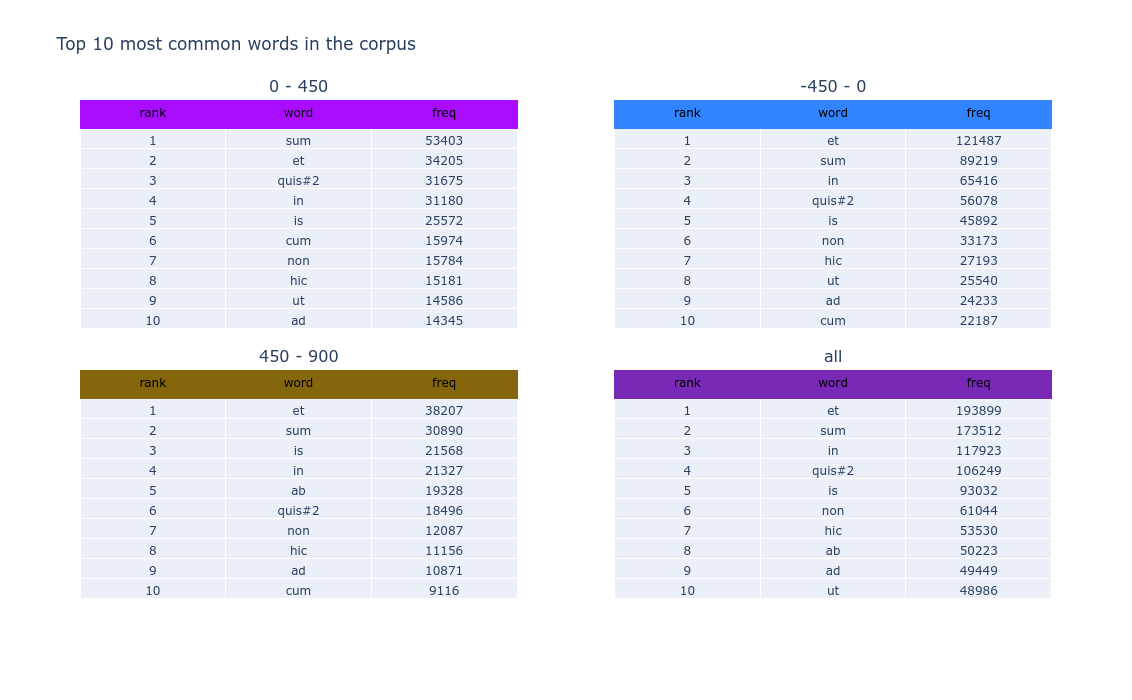

In [443]:
# most common lemmas in the corpus
top_display=10
for i,group in enumerate(most_common_df.groupby("period")):
    df = group[1][['rank', 'word', 'freq']].iloc[:top_display]
    tbl = go.Table(
        header=dict(
            values=['rank', 'word', 'freq'],
            line_color=periods2colors[group[0]],
            fill_color=periods2colors[group[0]],
            align='center',
            font=dict(color='black', size=12)
        ),
        cells=dict(
            values=[df[col] for col in df],
        ))
    fig.add_trace(tbl, row=rows_cols[i][0], col=rows_cols[i][1])

fig.update_layout(height=700, width=700, showlegend=False, title='Top '+str(top_display)+' most common words in the corpus')
fig.show()

### Corpus and subcorpora size

We are now collecting corpus counts for each period and the entire corpus.

In [444]:
corpus_stats = []
for period in latinise_period.conditions():
    corpus_stats.append((
        period,
        latinise_period[period].N(), #number of lemmas
        latinise_period[period].B(), #number of unique lemmas
        latinise_words_period[period].N(), #number of words
        latinise_words_period[period].B(), #number of unique words,
        metadata_df_subset[metadata_df_subset["period"] == period]["sents"].sum(), #total number of sentences,
        metadata_df_subset[metadata_df_subset["period"] == period]["sents"].mean(), #avg number of sentences,
        metadata_df_subset[metadata_df_subset["period"] == period]["sents_len_mean"].mean() #avg length of sentences
    )
    )

# add total counts
corpus_stats.append(
    (
        'all',
        latinise_freqs.N(),
        latinise_freqs.B(),
        latinise_words_freqs.N(),
        latinise_words_freqs.B(),
        metadata_df_subset["sents"].sum(), #total number of sentences,
        metadata_df_subset["sents"].mean(), #avg number of sentences,
        metadata_df_subset["sents_len_mean"].mean() #avg length of sentences
    )
)
#latinise_words_period['0 - 450'].B()
corpus_stats_df = pd.DataFrame.from_records(corpus_stats,
                                            columns=['period', 'lemmas', 'lemmas_u', 'words', 'words_u',
                                                    'sents_n', 'sents_n_mean', 'sents_len_mean'])
corpus_stats_df["period"] = corpus_stats_df["period"].astype("category") # cast to categorical to force custom sorting
corpus_stats_df['period'] = corpus_stats_df['period'].cat.reorder_categories(period_labels, ordered=True)
corpus_stats_df.sort_values(by='period',inplace=True)
corpus_stats_df.reset_index(inplace=True, drop=True)
corpus_stats_df["ttr"] = (corpus_stats_df["words_u"] / corpus_stats_df["words"]) * 100 # token-to-type ratio
corpus_stats_df.head()

period   lemmas  lemmas_u    words  words_u  sents_n  sents_n_mean  \
0   -450 - 0  1395938     44861  1395858   103432    64756    799.456790   
1    0 - 450  2800542     97396  2799762   195764   150433    629.426778   
2  450 - 900  1105178     50265  1105116    97905   103151   1586.938462   
3        all  5301658    142051  5300736   262883   318340    826.857143   

   sents_len_mean       ttr  
0       25.496100  7.409923  
1       24.379308  6.992166  
2       25.113017  8.859251  
3       24.738143  4.959368

In [445]:
# slides: corpus stats
import seaborn as sns
cm = sns.light_palette("seagreen", as_cmap=True)

corpus_stats_df.rename(columns={"period" : "Period", 
                                #'lemmas': 'Lemmas',
                                'lemmas_u': 'Unique lemmas',
                                'words': 'Tokens',
                                'words_u': 'Unique tokens',
                                #'ttr': 'Type/Token'
                               })\
                .style\
                .hide(axis="index")\
                .set_properties(subset=(slice(3,3), slice(None)),
                                **{'border-top': '2px solid;', 'font-weight': 'bold'})\
                .hide(subset=(['sents_n', 'sents_n_mean', 'sents_len_mean', 'ttr', 'lemmas']), axis="columns")\
                .set_table_styles([{"selector": "td", "props": "text-align: center;"}])\
                .background_gradient(cmap=cm,
                                     subset=(slice(0,2),
                                             ["Unique lemmas", "Tokens", "Unique tokens"]),
                                     axis=0)

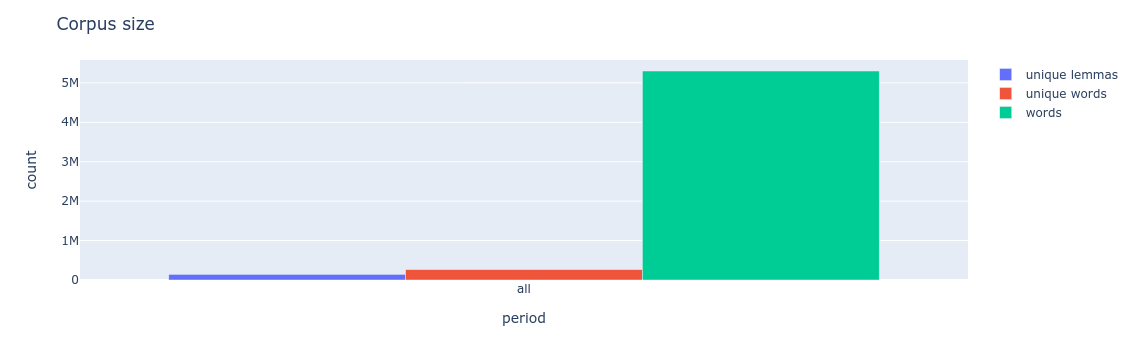

In [446]:
fig = px.bar(corpus_stats_df[corpus_stats_df["period"] == 'all'],
             x="period",
             y=["lemmas_u", "words_u", "words"],
             barmode="group",
             orientation='v',
            )
labels=dict(words="words", words_u="unique words", lemmas_u="unique lemmas")

fig.for_each_trace(lambda trace: trace.update(name = labels[trace.name]))

fig.update_layout(
    title="Corpus size",
    xaxis_title="period",
    yaxis_title="count",
    legend_title="",    
)

fig.show()

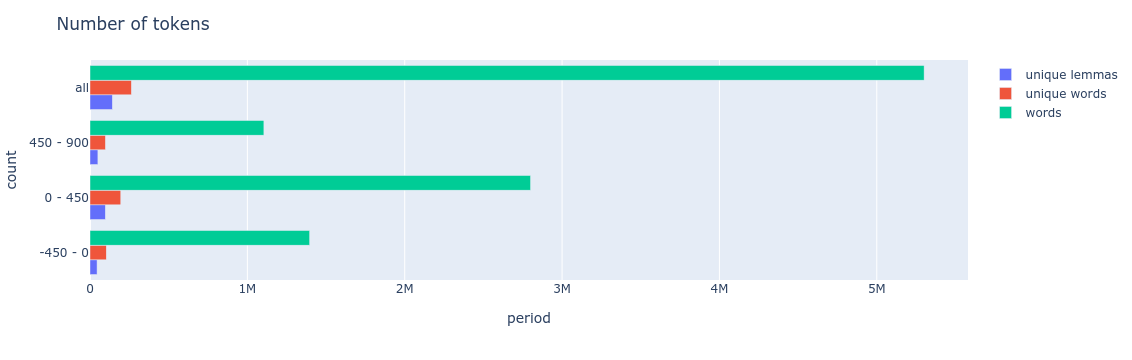

In [447]:
fig = px.bar(corpus_stats_df,
             y="period",
             x=["lemmas_u", "words_u", "words"],
             barmode="group",
             orientation='h',
            )
labels=dict(words="words", words_u="unique words", lemmas_u="unique lemmas")

fig.for_each_trace(lambda trace: trace.update(name = labels[trace.name]))

fig.update_layout(
    title="Number of tokens",
    xaxis_title="period",
    yaxis_title="count",
    legend_title="",    
)

fig.show()

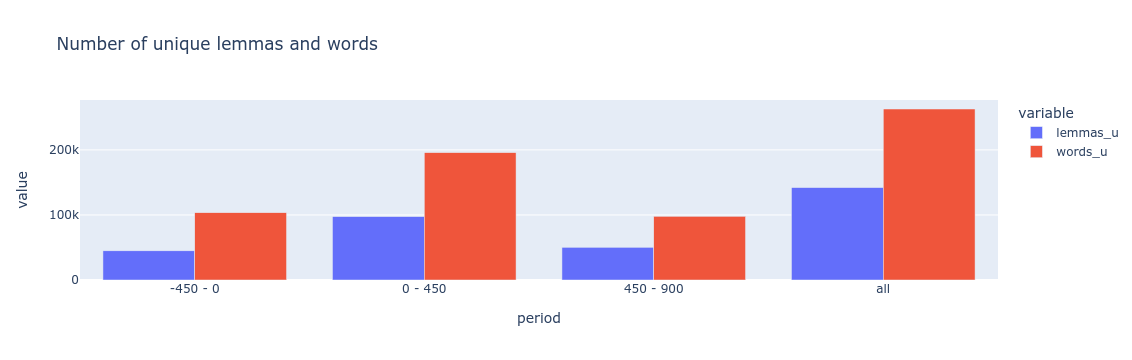

In [448]:
fig = px.bar(corpus_stats_df,
             x="period",
             y=["lemmas_u", "words_u",],
             title="Number of unique lemmas and words",
             barmode="group"
            )
fig.show()

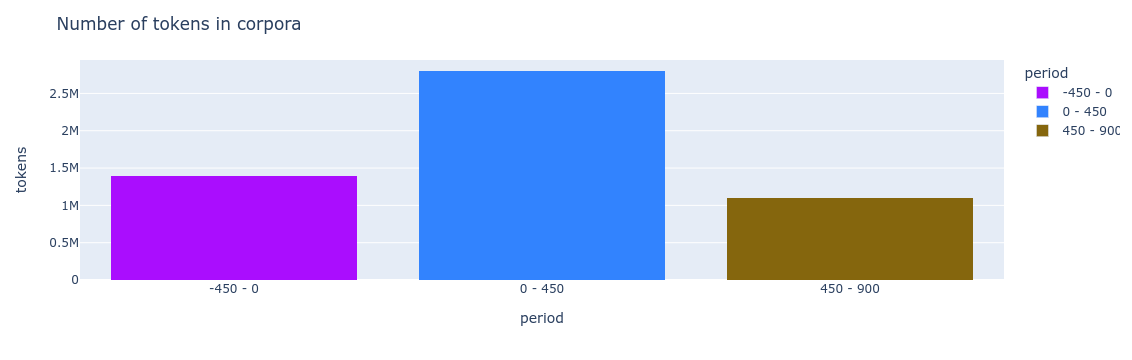

In [450]:
# number of tokens per period
df = metadata_df_subset.groupby("period").agg({"tokens":"sum"}).reset_index()
fig = px.bar(df, x="period", y="tokens", color="period", color_discrete_map=periods2colors)
fig.update_layout(title="Number of tokens in corpora",barmode='stack')
fig.show()

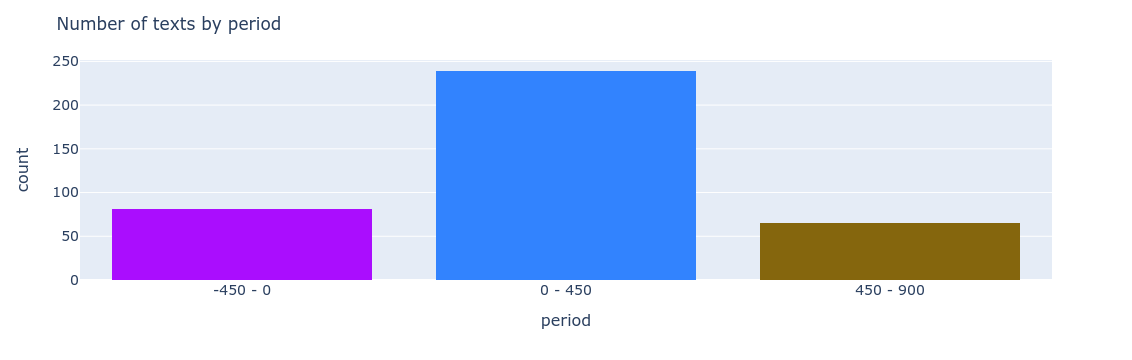

In [451]:
prettyprint = True

fig = px.histogram(metadata_df_subset,
                   x="period", y="file",
                   histfunc='count',
             #barmode="group",
                   category_orders={"period":period_labels[:len(period_labels)-1]},
             color="period", color_discrete_map=periods2colors)
fig.update_layout(title="Number of texts by period",barmode='stack', showlegend=False)
if prettyprint:
    fig.update_xaxes(title_font=dict(size=16), tickfont=dict(size=14))
    fig.update_yaxes(title_font=dict(size=16), tickfont=dict(size=14))
    fig.update_layout(showlegend=False, width=400, height=300)
fig.show()


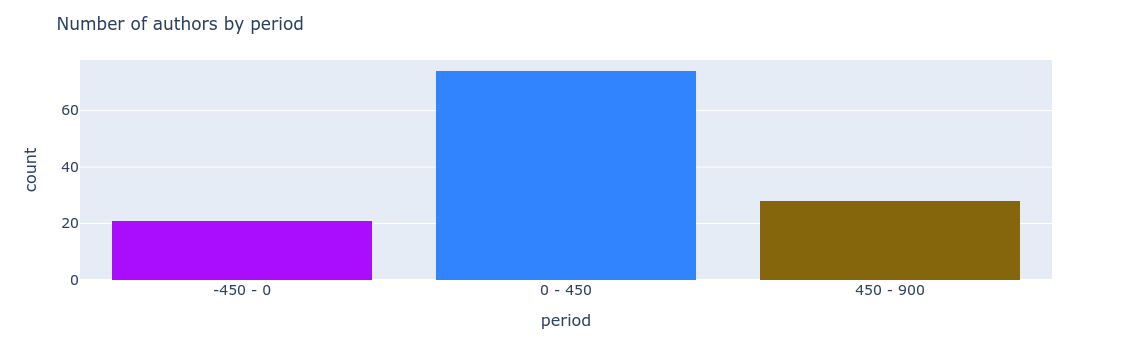

In [452]:
df = metadata_df_subset.groupby(["period", "creator"]).size().reset_index()
df.columns = ["period", "creator", "count"]
df = df[df["count"] > 0]
fig = px.histogram(df,
                   x="period", y=["count"],
                   histfunc='count',
             #barmode="group",
                   category_orders={"period":period_labels[:len(period_labels)-1]},
             color="period", color_discrete_map=periods2colors)
fig.update_layout(title="Number of authors by period",barmode='stack', showlegend=False)

if prettyprint:
    fig.update_xaxes(title_font=dict(size=16), tickfont=dict(size=14))
    fig.update_yaxes(title_font=dict(size=16), tickfont=dict(size=14))
    fig.update_layout(width=400, height=300)
fig.show()

__TODO__
- keywords (period vs. reference)
- rank/freq (period vs. reference)
- add from Voces (Kilgarriff, A. ‘Comparing Corpora’. International Journal of Corpus Linguistics 6, no. 1 (1 November 2001): 97–133. https://doi.org/10.1075/ijcl.6.1.05kil.)


## Socio-political terms

### Definining terms

We are interested in semantic change patterns of a set of terms related to the socio-political life, such as:

In [453]:
# define terms we're interested in
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator",
                         "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]
print(socio_political_terms)

['civitas', 'consilium', 'consul', 'dux', 'gens', 'hostis', 'imperator', 'jus', 'labor', 'natio', 'nobilitas', 'pontifex', 'pontificium', 'populus', 'potestas', 'regnum', 'senatus', 'sodes', 'urbs']


We're assigning each term a seperate colour to facilitate our analyses.

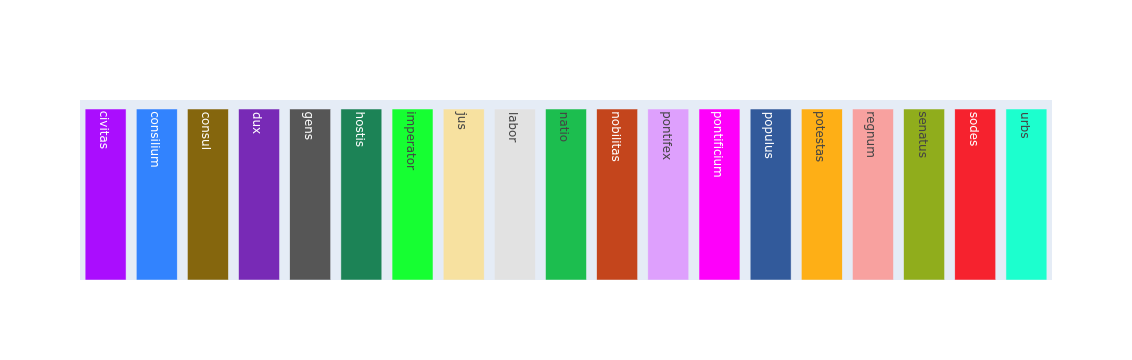

In [454]:
color_discrete_map_terms = { term : px.colors.qualitative.Alphabet[i] for i, term in enumerate(socio_political_terms)} # for each term we fix a color
fig = go.Figure()
fig.add_trace(go.Bar(
    x = [col for col in color_discrete_map_terms.keys()],
    y = [0.5 for x in range(0, len(color_discrete_map_terms)) ],
    text = socio_political_terms,
    textangle=90,
    marker_color=[col for col in color_discrete_map_terms.values()]
))
fig.update_layout(showlegend=False, xaxis={'showgrid': False, 'visible': False}, yaxis={'showgrid': False, 'visible': False})

Let's define a single term for in-depth analysis.

In [458]:
selected = 'civitas'
# re-assign the variable for code consistency
terms = socio_political_terms

# Word frequency

## Prepare the data

Let's count wordforms by year ...

In [465]:
wordforms_by_year = pd.DataFrame([ (year, term, counts[term]) for year, counts in cfd_year_tokens.items() 
                                  for term in cfd_year_tokens[year].keys() 
                                  if term.startswith('civit') or term.startswith('ciuit') ],
                             columns = ["year", "term", "count"])
# frequency by century
century = [-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900]
wordforms_by_year["century"] = pd.cut(wordforms_by_year["year"], bins=century, 
                                  labels=[y for y in range(-5,0)]+[y for y in range(1,10)], include_lowest=True)
wordforms_by_year["period"] = pd.cut(wordforms_by_year["year"],bins=intervals,labels=intervals_labels,include_lowest=True)
wordforms_by_year.head()

year       term  count century   period
0   382  civitatem    311       4  0 - 450
1   382  civitatis    151       4  0 - 450
2   382    civitas    109       4  0 - 450
3   382   civitate    201       4  0 - 450
4   382  civitates    198       4  0 - 450

... and lemma counts by year.

In [470]:
# count term frequency by year
terms_by_year = pd.DataFrame([ (year, term, counts[term]) for year, counts in cfd_year.items() for term in terms ],
                             columns = ["year", "term", "count"])
terms_by_year["year"] = pd.to_numeric(terms_by_year["year"])
#terms_by_year["term"].astype("category")
terms_by_year["count"] = pd.to_numeric(terms_by_year["count"])
terms_by_year["period"] = pd.cut(terms_by_year["year"],bins=intervals,labels=intervals_labels,include_lowest=True)
terms_by_year.tail()

year      term  count     period
2066   533  potestas    170  450 - 900
2067   533    regnum      0  450 - 900
2068   533   senatus      9  450 - 900
2069   533     sodes      0  450 - 900
2070   533      urbs      9  450 - 900

Count cumulative frequency of terms in the corpus.

In [468]:
freq_in_corpus = pd.DataFrame(terms_by_year.groupby(["term"]).agg({"count":sum}).reset_index())
freq_in_corpus["ppm"] = (np.array(freq_in_corpus["count"]) / np.array(corpus_stats_df[corpus_stats_df["period"] == "all"]["lemmas"])) * 1000000

term  count          ppm
0    civitas   5527  1042.504062
1  consilium   3434   647.721901
2     consul   5691  1073.437781
3        dux   2992   564.351756
4       gens   3837   723.735858

## Distribution of the terms in the corpus

### By year

Let's analyze the distribution of all the terms in our corpus.

In [472]:
freq_in_corpus.head()

term  count          ppm
0    civitas   5527  1042.504062
1  consilium   3434   647.721901
2     consul   5691  1073.437781
3        dux   2992   564.351756
4       gens   3837   723.735858

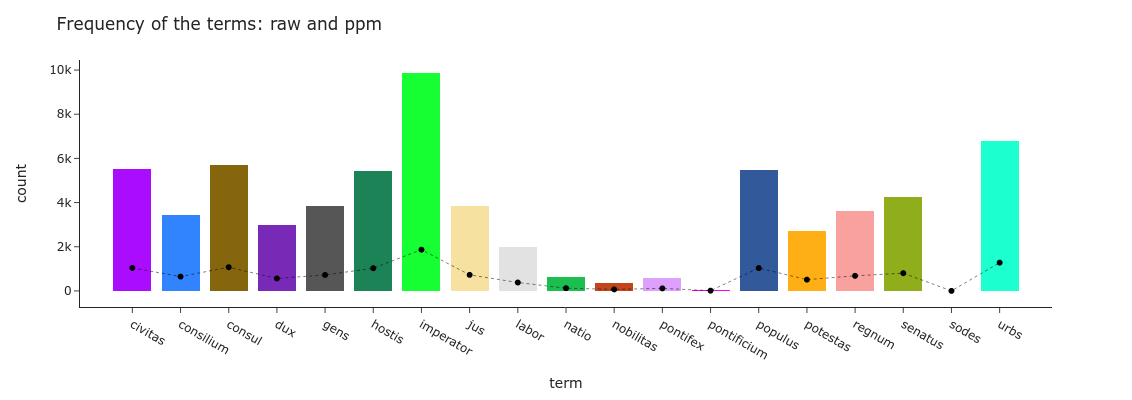

In [473]:
fig = px.bar(freq_in_corpus,x="term", y="count", color="term", color_discrete_map=color_discrete_map_terms)
fig.add_scatter(x=freq_in_corpus["term"], y=freq_in_corpus["ppm"], mode="markers+lines", line=dict(dash='dot', color="black", width=0.5))
fig.update_layout(title="Frequency of the terms: raw and ppm", height=400, width=800, barmode="stack", template="simple_white", showlegend=False)
fig.show()

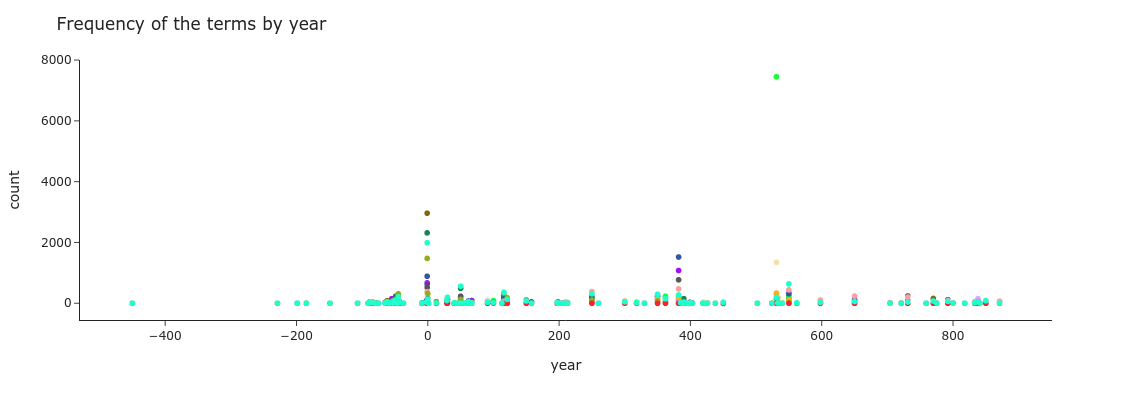

In [474]:
fig = px.scatter(terms_by_year,x="year", y="count", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Frequency of the terms by year", height=400, width=500, template="simple_white", showlegend=False)
fig.show()

#### Selected term

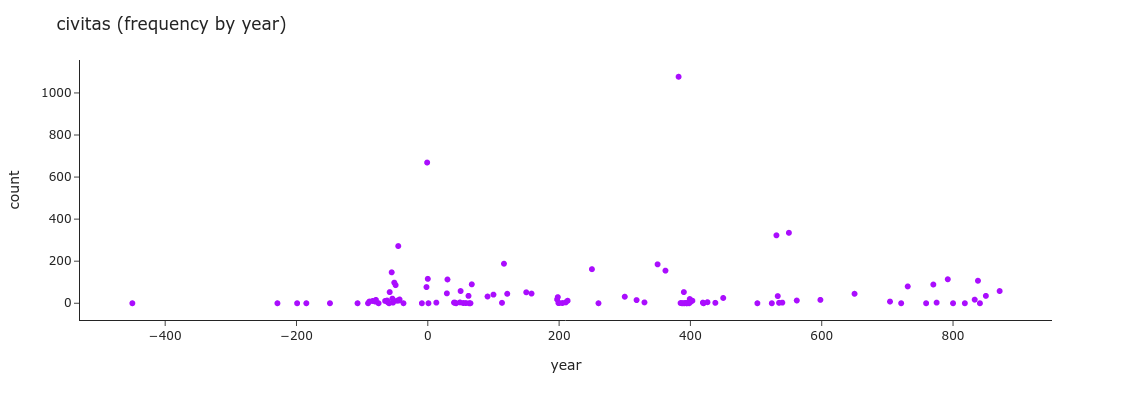

In [476]:
fig = px.scatter(terms_by_year[terms_by_year["term"] == selected],x="year", y="count", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title=selected + " (frequency by year)", height=400, width=500, template="simple_white", showlegend=False)
fig.show()

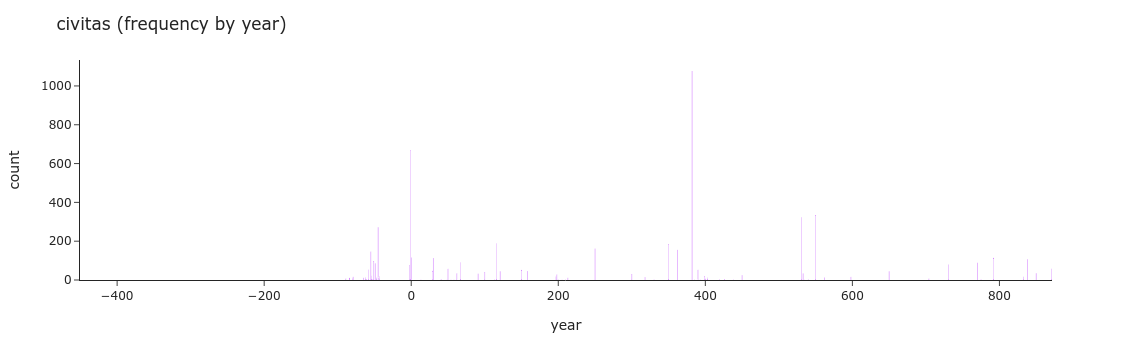

In [477]:
fig = px.bar(terms_by_year[terms_by_year["term"] == selected],x="year", y="count", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title=selected + " (frequency by year)", height=200, width=800, template="simple_white", showlegend=False, barmode="stack")
fig.show()

### By period

In [483]:
#count tokens by year
freq_by_year = pd.DataFrame()
freq_by_year["year"] = pd.to_numeric(cfd_year.conditions())
freq_by_year["count"] = [ sum(cfd_year[year].values()) for year in freq_by_year["year"] ]
freq_by_year["period"] = pd.cut(freq_by_year["year"], bins=intervals,labels=intervals_labels,include_lowest=True)

In [484]:
# by period (ppm)
import numpy as np
freq_by_period = freq_by_year.groupby(["period"], as_index=False).agg({'count' : np.sum}) #all tokens by period
terms_by_period = terms_by_year.groupby(["term","period"], as_index=False).agg({'count' : np.sum})
counts_by_period = pd.merge(terms_by_period, freq_by_period, on=["period"], how="right")["count_y"]
terms_by_period["ppm"] = ( terms_by_period["count"] / counts_by_period ) * 1000000
terms_by_period.head()

term     period  count          ppm
0    civitas   -450 - 0   1658  1187.731833
1    civitas    0 - 450   2587  1853.234169
2    civitas  450 - 900   1282   918.378896
3  consilium   -450 - 0   1526  1093.171760
4  consilium    0 - 450   1431  1025.117161

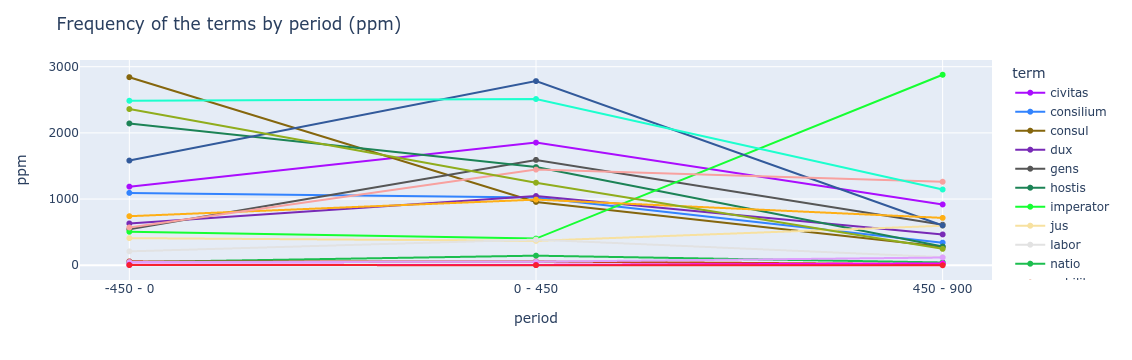

In [485]:
fig = px.line(terms_by_period, x="period", y="ppm", color="term", color_discrete_map=color_discrete_map_terms, markers=True)
fig.update_layout(title="Frequency of the terms by period (ppm)",width=400 )
fig.show()

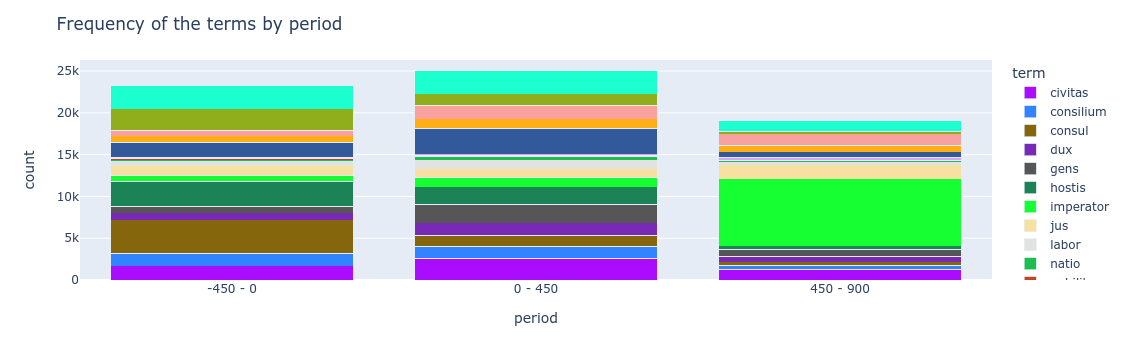

In [486]:
# by period (raw counts)
fig = px.bar(terms_by_period,x="period", y="count", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Frequency of the terms by period",barmode='stack')
fig.show()

#### Selected term

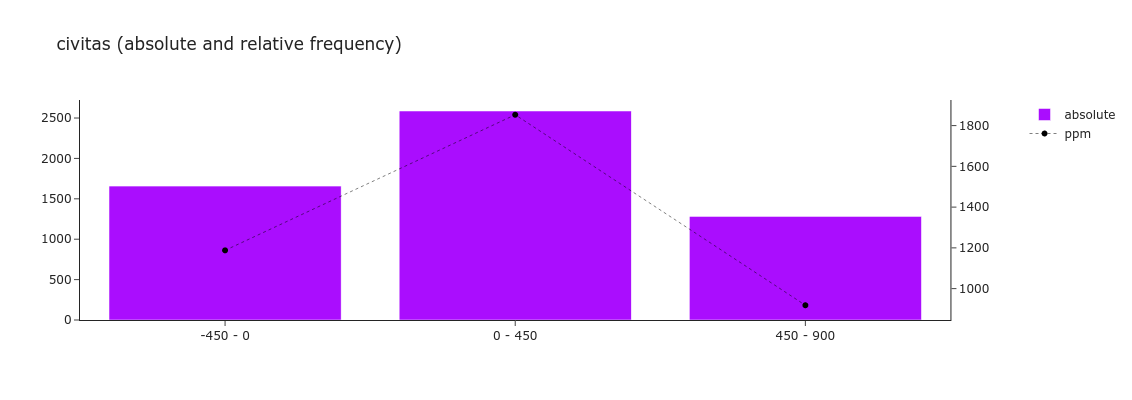

In [489]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
#fig = go.Figure()
fig.add_trace(go.Bar(x=terms_by_period[terms_by_period["term"] == selected]["period"], 
                     y=terms_by_period[terms_by_period["term"] == selected]["count"], name="absolute",
                      marker_color=color_discrete_map_terms[selected]
                    ),  secondary_y=False
             )
fig.add_trace(go.Scatter(x=terms_by_period[terms_by_period["term"] == selected]["period"], 
                         y=terms_by_period[terms_by_period["term"] == selected]["ppm"],
                         mode="markers+lines", line=dict(dash='dot', color="black", width=0.5,), 
                         name="ppm"),
              secondary_y=True
             )
fig.update_xaxes(type='category') #force categorical to remove ) century
fig.update_layout(title=selected+" (absolute and relative frequency)", width=600, template="simple_white",
                 height=400)

### By century

In [497]:
# frequency by century
century = [-501,-401,-301,-201,-101,0,101,201,301,401,501,601,701,801,901]
freq_by_year["century"] = pd.cut(freq_by_year["year"], bins=century, 
                                  labels=[y for y in range(-5,0)]+[y for y in range(1,10)])

freq_by_year.head()

year   count     period century
0   382  574277    0 - 450       4
1    -9   14917   -450 - 0      -1
2   524   11675  450 - 900       6
3   399   19543    0 - 450       4
4   391    7085    0 - 450       4

In [498]:
freq_by_century = freq_by_year.groupby(["century"], as_index=False).agg({'count' : np.sum}) #all tokens by period
freq_by_century.tail()

century   count
9        5   81991
10       6  792427
11       7   22531
12       8  188490
13       9  101730

In [499]:
# frequency by century
century = [-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900]
terms_by_year["century"] = pd.cut(terms_by_year["year"], bins=century, 
                                  labels=[y for y in range(-5,0)]+[y for y in range(1,10)], include_lowest=True)

In [500]:
terms_by_century = terms_by_year.groupby(["term","century"]).agg({'count' : np.sum}).reset_index(drop=False)

In [501]:
counts_by_century = pd.merge(terms_by_century, freq_by_century, on=["century"], how="right")["count_y"]
terms_by_century["ppm"] = ( terms_by_century["count"] / counts_by_century ) * 1000000
terms_by_century["century"].cat.remove_unused_categories() # remove 0 century
terms_by_century.head()

term century  count           ppm
0  civitas      -5      0  0.000000e+00
1  civitas      -4      0  0.000000e+00
2  civitas      -3      0  0.000000e+00
3  civitas      -2      0  0.000000e+00
4  civitas      -1   1658  3.042202e+06

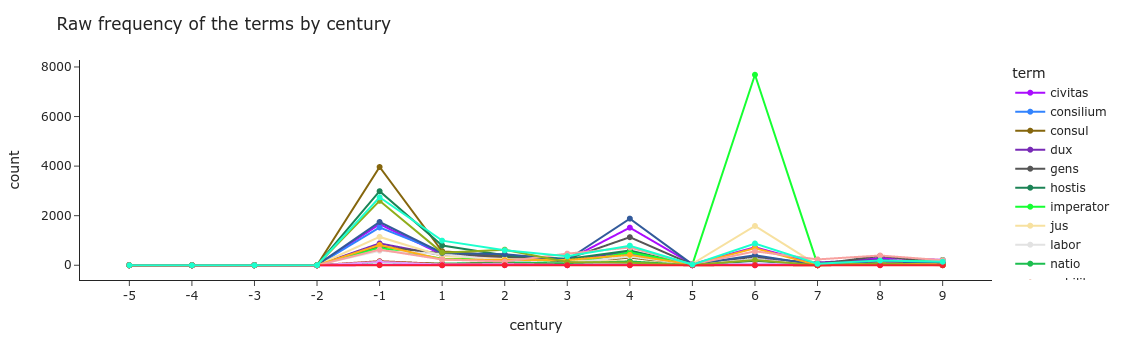

In [502]:
fig = px.line(terms_by_century,x="century", y="count", color="term", color_discrete_map=color_discrete_map_terms,
              markers = "lines+markers", )
fig.update_xaxes(type='category') #force categorical to remove ) century
fig.update_layout(title="Raw frequency of the terms by century", width=300, template="simple_white")
fig.show()

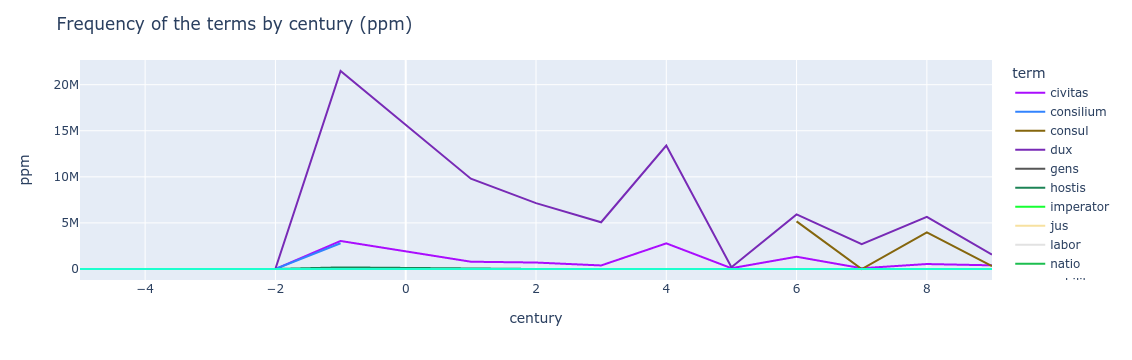

In [503]:
fig = px.line(terms_by_century,x="century", y="ppm", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Frequency of the terms by century (ppm)")
fig.show()

#### Variation

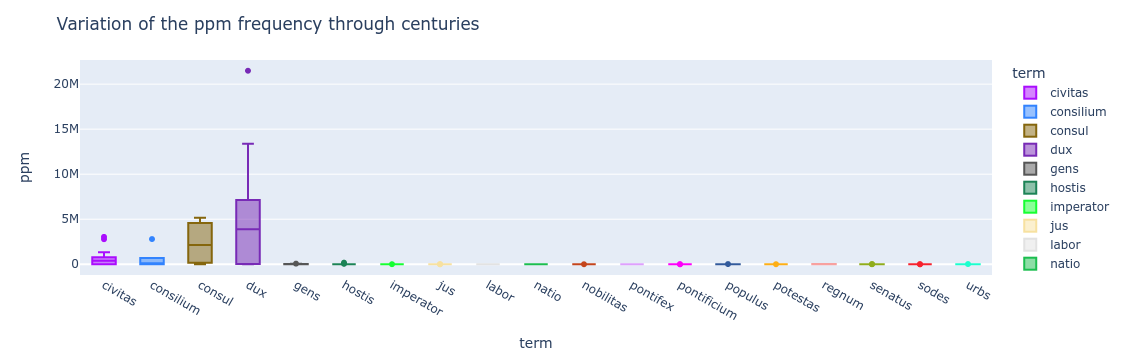

In [64]:
fig = px.box(terms_by_century,x="term", y="ppm", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Variation of the ppm frequency through centuries")
fig.show()

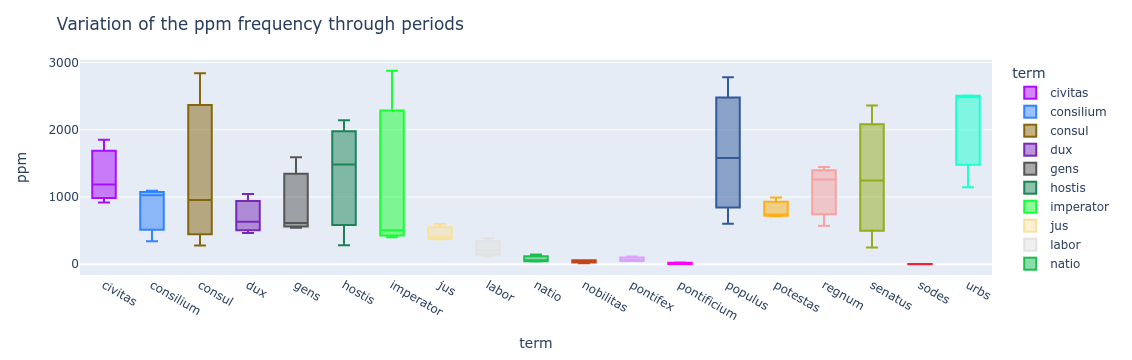

In [65]:
fig = px.box(terms_by_period,x="term", y="ppm", color="term", color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Variation of the ppm frequency through periods")
fig.show()

#### Selected term

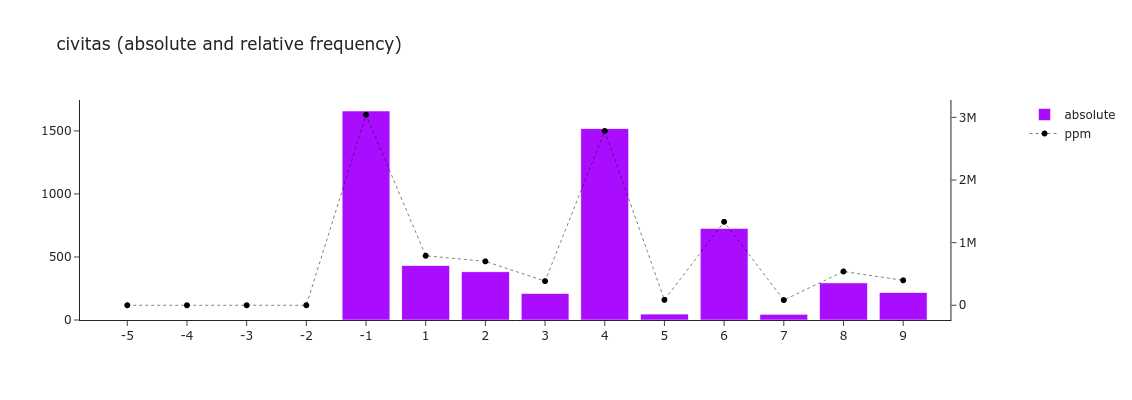

In [505]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
#fig = go.Figure()
fig.add_trace(go.Bar(x=terms_by_century[terms_by_century["term"] == selected]["century"], 
                     y=terms_by_century[terms_by_century["term"] == selected]["count"], name="absolute",
                      marker_color=color_discrete_map_terms[selected]
                    ),  secondary_y=False
             )
fig.add_trace(go.Scatter(x=terms_by_century[terms_by_century["term"] == selected]["century"], 
                         y=terms_by_century[terms_by_century["term"] == selected]["ppm"],
                         mode="markers+lines", line=dict(dash='dot', color="black", width=0.5,), 
                         name="ppm"),
              secondary_y=True
             )
fig.update_xaxes(type='category') #force categorical to remove ) century
fig.update_layout(title=selected+" (absolute and relative frequency)", width=600, template="simple_white",
                 height=400)

In [506]:
wordforms_by_year["term"] = [ term.replace('v', 'u') for term in wordforms_by_year["term"] ]
wordforms_by_year["term"] = [ term.replace('que', '') for term in wordforms_by_year["term"] ]
wordforms_by_year = wordforms_by_year[~ wordforms_by_year["term"].isin(['ciuitatulae', 'ciuitatium', 'ciuitatulam', 'ciuitatebus', 'ciuitato',
       'ciuitatulas', 'ciuitatiumportae', 'ciuitassimul', 'ciuita', 'ciuitat', 'ciuit']) ]
wordforms_by_year["term"] = wordforms_by_year["term"].astype('category')
wordforms_order = ['ciuitas', 'ciuitatis', 'ciuitati', 'ciuitatem', 'ciuitate', 'ciuitates', 'ciuitatum', 'ciuitatibus']
wordforms_by_year["term"].cat.reorder_categories(wordforms_order, ordered=True)
wordforms_order_numbers = dict.fromkeys(['ciuitas', 'ciuitatis', 'ciuitati', 'ciuitatem', 'ciuitate'], "sg")
wordforms_order_numbers.update(dict.fromkeys( ['ciuitates', 'ciuitatum', 'ciuitatibus'], 'pl'))
wordforms_by_year["number"] = [ wordforms_order_numbers[term] for term in wordforms_by_year["term"] ]

## Distribution of the word forms in the corpus

In [508]:
wordforms_by_period = wordforms_by_year.groupby(["period","term", "number"])["count"].sum().reset_index()
wordforms_by_period = wordforms_by_period[wordforms_by_period["count"] > 0]
wordforms_by_period.head()

period       term number  count
1  -450 - 0    ciuitas     sg    221
3  -450 - 0   ciuitate     sg    321
5  -450 - 0  ciuitatem     sg    220
6  -450 - 0  ciuitates     pl    201
9  -450 - 0   ciuitati     sg     71

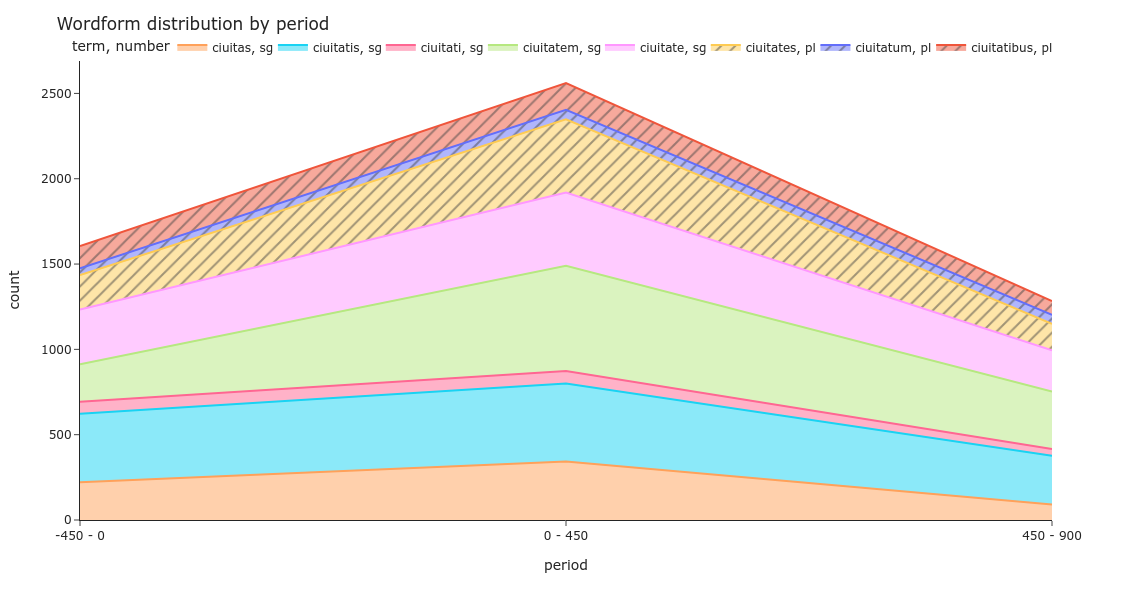

In [509]:
# by period (raw counts)
fig = px.area(wordforms_by_period,x="period", y="count",
              pattern_shape="number",
             category_orders={"period":intervals_labels, 
                              "term": wordforms_order
                             },
                   color="term", color_discrete_map=periods2colors)
fig.update_layout(title="Wordform distribution by period", template="simple_white", showlegend=True, height=600, width=900,
                 legend=dict(
    orientation="h",
    yanchor="top",
    y=1.06,
    xanchor="right",
    x=1
))
fig.show()

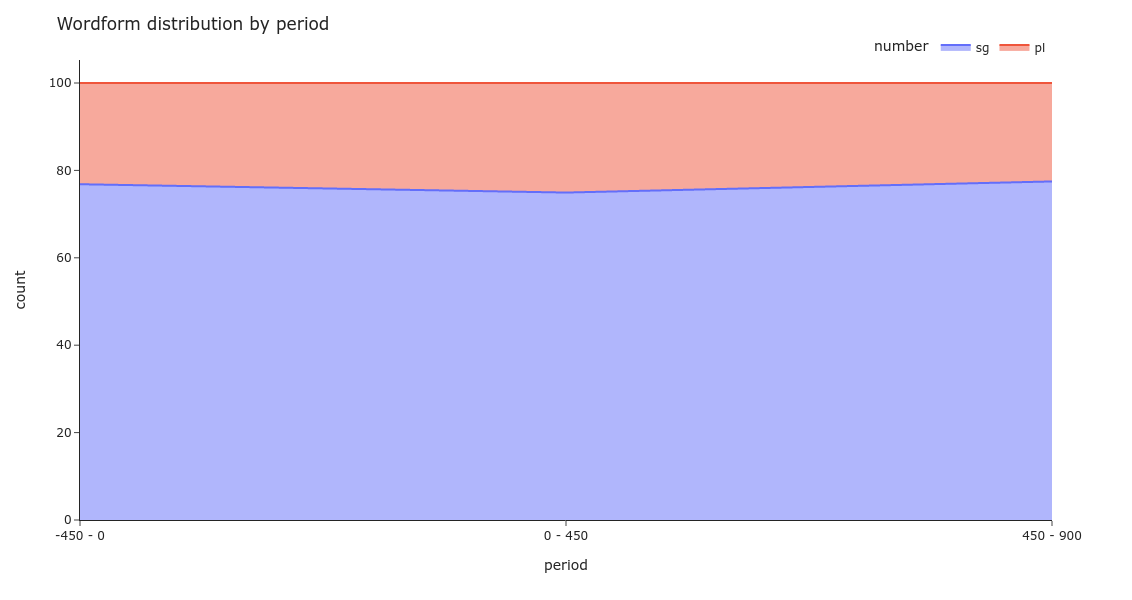

In [510]:
wordforms_by_period_number = wordforms_by_year.groupby(["period","number"])["count"].sum().reset_index()
wordforms_by_period_number = wordforms_by_period_number[wordforms_by_period_number["count"] > 0]
wordforms_by_period_number.head()
fig = px.area(wordforms_by_period_number, x="period", y="count",
              groupnorm='percent',
              category_orders={"period":intervals_labels, 
                              "term": wordforms_order,
                               "number": ["sg", "pl"]
                             },
                   color="number")
fig.update_layout(title="Wordform distribution by period", template="simple_white", showlegend=True, height=600, width=900,
                 legend=dict(
    orientation="h",
    yanchor="top",
    y=1.06,
    xanchor="right",
    x=1
))
fig.show()

## Texts with largest number of term occurrences

### Prepare the data

In [513]:
#by fileid - prepare freq distribution
import itertools
cfd_bytext = nltk.ConditionalFreqDist()
for file in [ x for x in latinise.fileids() ]:
    for word in latinise.words(file):
        cfd_bytext[file][word] +=1

In [514]:
terms_by_text = pd.DataFrame([ (filename, term, counts[term]) for filename, counts in cfd_bytext.items() for term in terms ],
                             columns = ["file", "term", "count"])
terms_by_text = pd.merge(terms_by_text, metadata_df_subset, on="file")
terms_by_text['ppm'] = (terms_by_text['count'] / terms_by_text['tokens']) * 1000000
terms_by_text.sort_values("count", ascending=False).head()

file       term  count          id            title  \
5839  lat_0531_IT-LAT0867.txt  imperator   7451  IT-LAT0867            Codex   
1256  lat_-001_IT-LAT0142.txt     consul   2963  IT-LAT0142  Ab Urbe condita   
1259  lat_-001_IT-LAT0142.txt     hostis   2315  IT-LAT0142  Ab Urbe condita   
1272  lat_-001_IT-LAT0142.txt       urbs   1990  IT-LAT0142  Ab Urbe condita   
1270  lat_-001_IT-LAT0142.txt    senatus   1475  IT-LAT0142  Ab Urbe condita   

                                                creator  date   type  \
5839  Iustinianus, Caesar Flavius (Imperator Iustini...   531  prose   
1256                                      Livius, Titus    -1  prose   
1259                                      Livius, Titus    -1  prose   
1272                                      Livius, Titus    -1  prose   
1270                                      Livius, Titus    -1  prose   

     time_interval        abbr     period  sents  sents_len_mean  tokens  \
5839           450  Cod. Iust.  450 - 900  68098        8.786029  405280   
1256          -450        Liv.   -450 - 0  21104       28.683614  504557   
1259          -450        Liv.   -450 - 0  21104       28.683614  504557   
1272          -450        Liv.   -450 - 0  21104       28.683614  504557   
1270          -450        Liv.   -450 - 0  21104       28.683614  504557   

      lemmas_unique  tokens_unique century           ppm  
5839          13624          32200       6  18384.820371  
1256          21753          50577      -1   5872.478233  
1259          21753          50577      -1   4588.183297  
1272          21753          50577      -1   3944.053893  
1270          21753          50577      -1   2923.356529

### By text

In [535]:
# top works by period - raw
top_terms_by_text = terms_by_text.sort_values('count', ascending=False).groupby(["period","term"]).head(5).sort_values("count", ascending=False)

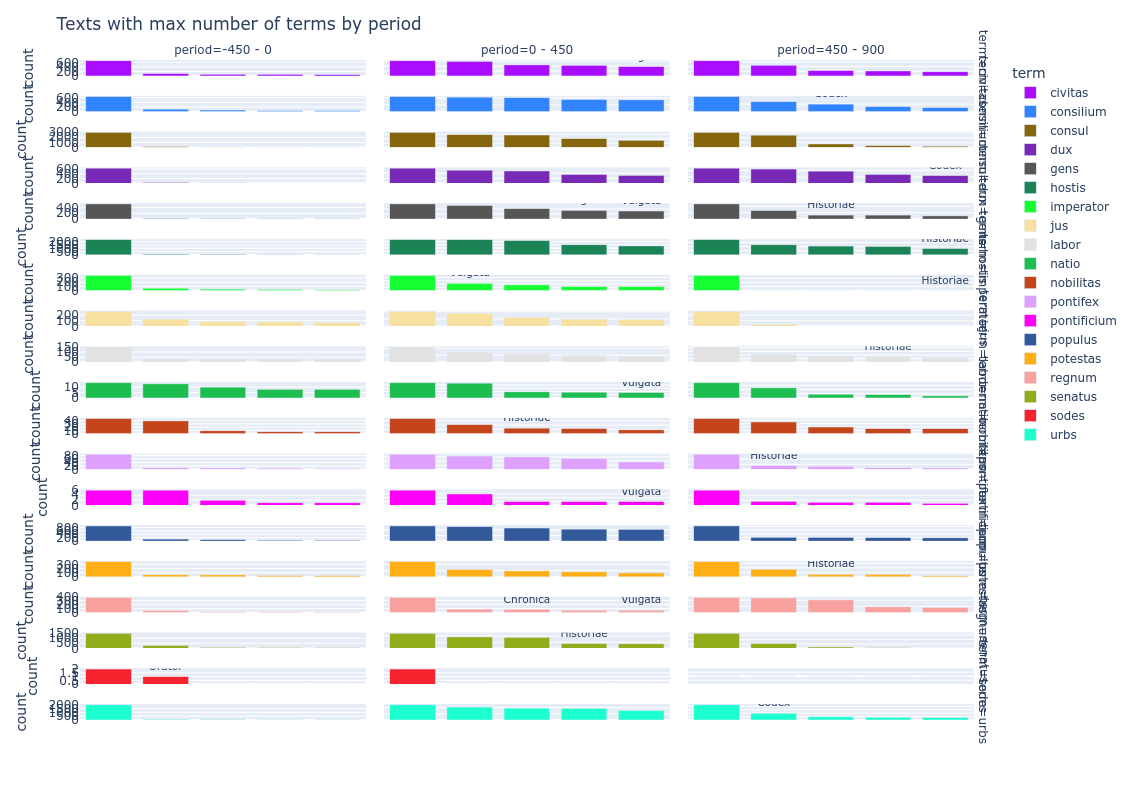

In [536]:
fig = px.bar(top_terms_by_text,x="id", y="count", color="term", facet_col="period",
             facet_row="term", text="title", facet_col_wrap=2, category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=800, hover_data=["id", "creator", "title", "period"], color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Texts with max number of terms by period", uniformtext_minsize=10, uniformtext_mode='hide')
fig.update_xaxes(matches=None, visible=False)
fig.update_yaxes(matches=None)
fig.show()

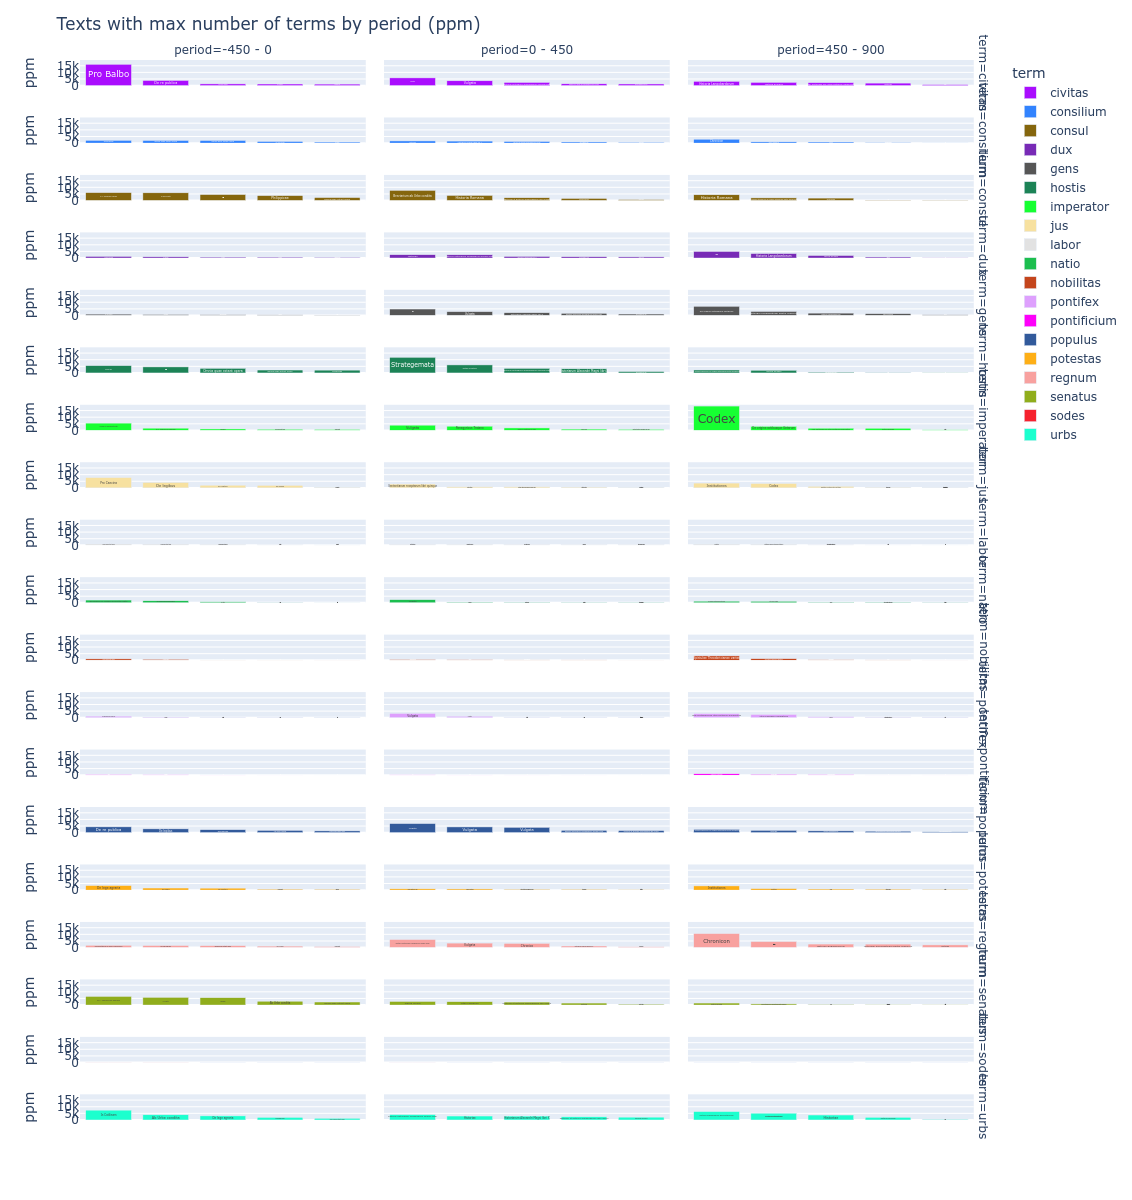

In [537]:
# top works by period - ppm
#top_terms_by_text = terms_by_text.sort_values('ppm', ascending=False).groupby(["period","term"]).head(5).sort_values("ppm", ascending=False)
fig = px.bar(top_terms_by_text.sort_values("ppm", ascending=False),x="id", y="ppm", color="term", facet_col="period", facet_row="term", text="title", 
             #facet_col_wrap=,
             category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=1200, hover_data=["id", "creator", "title", "period"], color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Texts with max number of terms by period (ppm)",
                  uniformtext_minsize=14)
fig.update_xaxes(matches=None, visible=False)
fig.update_traces(textposition='inside', textfont_size=16)
fig.show()

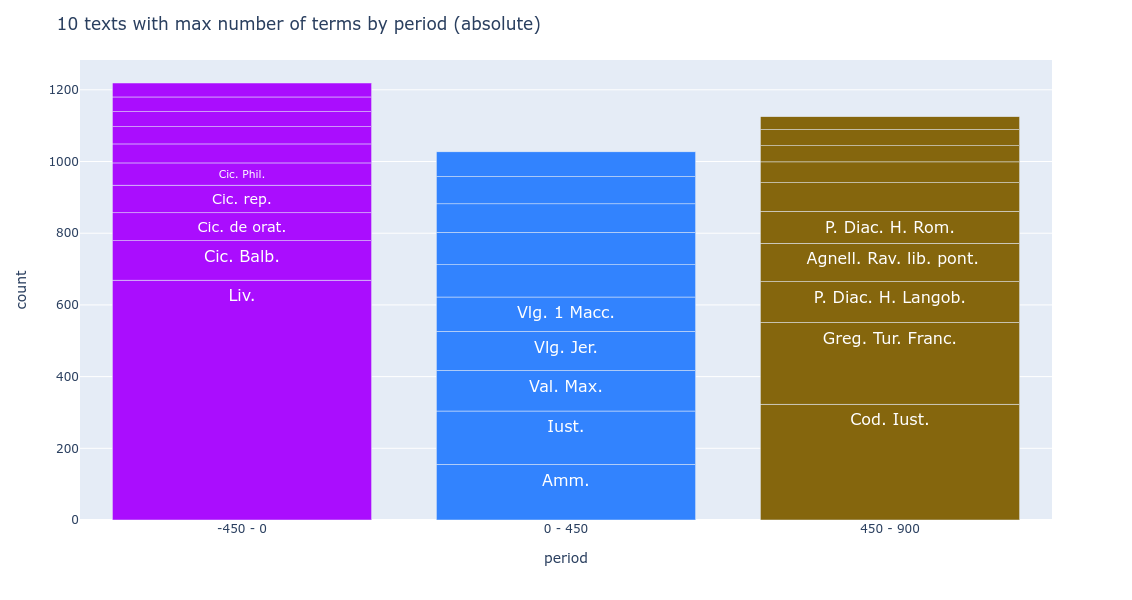

In [538]:
# 10 top works by period - raw
top_terms_by_text = terms_by_text.sort_values('count', ascending=False).groupby(["period","term"]).head(10).sort_values("count", ascending=False)
fig = px.bar(top_terms_by_text[top_terms_by_text["term"] == selected].sort_values("count", ascending=False),
             x="period", y="count", color="period",text="abbr", color_discrete_map=periods2colors,
             #facet_col_wrap=, facet_col="period", facet_row="term", 
             category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=600, hover_data=["id", "creator", "title", "period"], 
             #color_discrete_map=color_discrete_map_terms
            )
fig.update_layout(title="10 texts with max number of terms by period (absolute)",
                  uniformtext_minsize=16, showlegend=False)
fig.update_xaxes(matches=None, visible=True)
fig.update_traces(textposition='inside', textfont_size=16)
fig.show()

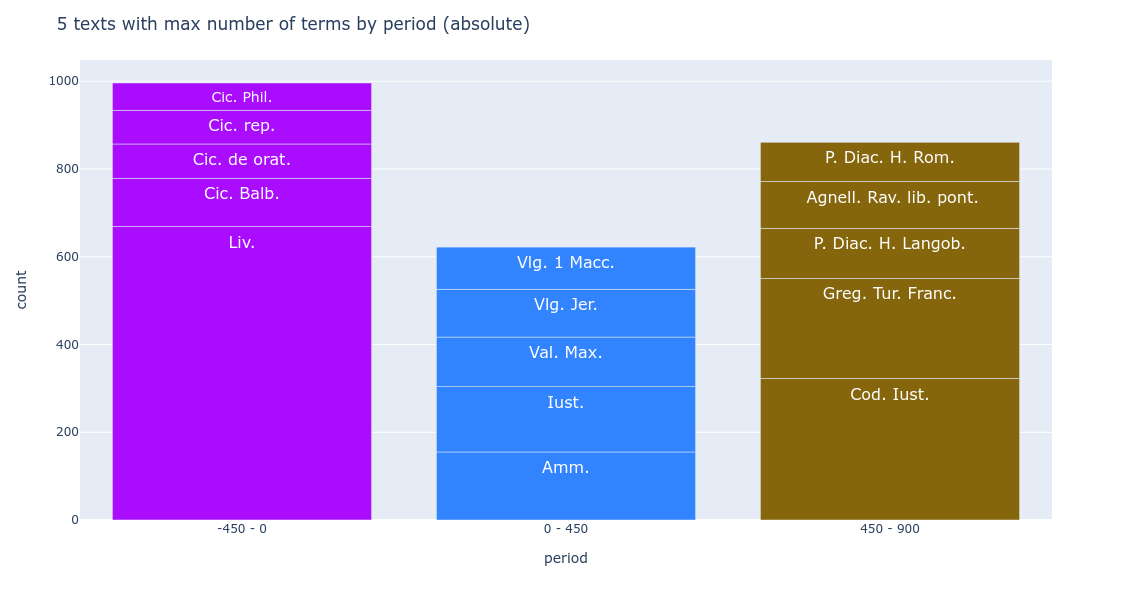

In [539]:
# top works by period
top_terms_by_text = terms_by_text.sort_values('count', ascending=False).groupby(["period","term"]).head(5).sort_values("count", ascending=False)
fig = px.bar(top_terms_by_text[top_terms_by_text["term"] == selected].sort_values("count", ascending=False),
             x="period", y="count", color="period",text="abbr", color_discrete_map=periods2colors,
             #facet_col_wrap=, facet_col="period", facet_row="term", 
             category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=600, hover_data=["id", "creator", "title", "period"], 
             #color_discrete_map=color_discrete_map_terms
            )
fig.update_layout(title="5 texts with max number of terms by period (absolute)",
                  uniformtext_minsize=16, showlegend=False)
fig.update_xaxes(matches=None, visible=True)
fig.update_traces(textposition='inside', textfont_size=16)
fig.show()

In [540]:
# top works by period -
top_terms_by_title = terms_by_text.sort_values('count', ascending=False)[["period", "creator","title", "count", "term"]]
top_terms_by_title["creator"] = top_terms_by_title["creator"].apply(lambda x: x.strip())
top_terms_by_title["title"] = top_terms_by_title["title"].apply(lambda x: x.strip())
top_terms_by_title["creator_title"] = top_terms_by_title["creator"] + "_" + top_terms_by_title["title"]
top_terms_by_title.sort_values("count", ascending = False)

period                                            creator  \
5839  450 - 900  Iustinianus, Caesar Flavius (Imperator Iustini...   
1256   -450 - 0                                      Livius, Titus   
1259   -450 - 0                                      Livius, Titus   
1272   -450 - 0                                      Livius, Titus   
1270   -450 - 0                                      Livius, Titus   
...         ...                                                ...   
5596    0 - 450                                         Hieronymus   
6909    0 - 450                                         Hieronymus   
5597    0 - 450                                         Hieronymus   
5598    0 - 450                                         Hieronymus   
3657  450 - 900                               Martinus Bracarensis   

                title  count         term  \
5839            Codex   7451    imperator   
1256  Ab Urbe condita   2963       consul   
1259  Ab Urbe condita   2315       hostis   
1272  Ab Urbe condita   1990         urbs   
1270  Ab Urbe condita   1475      senatus   
...               ...    ...          ...   
5596          Vulgata      0    nobilitas   
6909          Vulgata      0  pontificium   
5597          Vulgata      0     pontifex   
5598          Vulgata      0  pontificium   
3657        De Pascha      0        natio   

                                          creator_title  
5839  Iustinianus, Caesar Flavius (Imperator Iustini...  
1256                      Livius, Titus_Ab Urbe condita  
1259                      Livius, Titus_Ab Urbe condita  
1272                      Livius, Titus_Ab Urbe condita  
1270                      Livius, Titus_Ab Urbe condita  
...                                                 ...  
5596                                 Hieronymus_Vulgata  
6909                                 Hieronymus_Vulgata  
5597                                 Hieronymus_Vulgata  
5598                                 Hieronymus_Vulgata  
3657                     Martinus Bracarensis_De Pascha  

[7315 rows x 6 columns]

In [541]:
#top_terms_by_title = top_terms_by_title.groupby(["creator_title", "period", "creator", "title", "term"]).agg({'count':np.sum})
#top_terms_by_title = top_terms_by_title[top_terms_by_title['count'] > 0] # keep only > 0
#top_terms_by_title.sort_values('count', ascending=True)
#top_terms_by_title.head()

In [542]:
top_terms_by_title_sel = top_terms_by_title[top_terms_by_title["term"] == selected].sort_values(by=["count"], ascending=False)\
.groupby("period").head(5).sort_values("period")

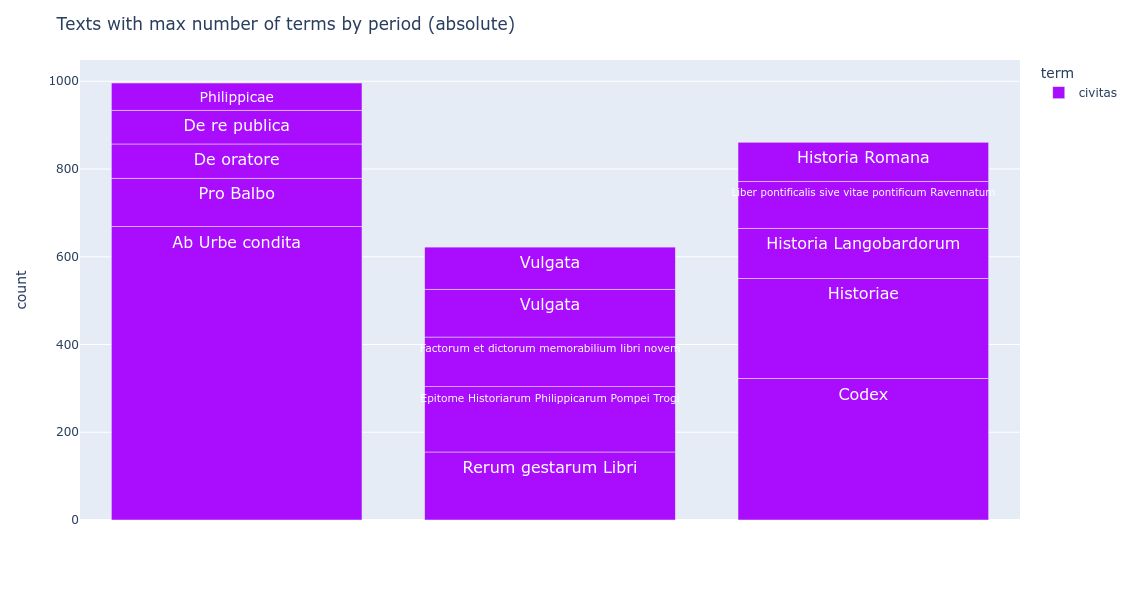

In [543]:
# top works by period - ppm
#top_terms_by_text = terms_by_text.sort_values('ppm', ascending=False).groupby(["period","term"]).head(5).sort_values("ppm", ascending=False)
fig = px.bar(top_terms_by_text[top_terms_by_text["term"] == selected].sort_values("count", ascending=False),
             x="period", y="count", color="term",text="title", 
             #facet_col_wrap=, facet_col="period", facet_row="term", 
             category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=600, hover_data=["id", "creator", "title", "period"], color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Texts with max number of terms by period (absolute)",
                  uniformtext_minsize=14)
fig.update_xaxes(matches=None, visible=False)
fig.update_traces(textposition='inside', textfont_size=16)
fig.show()

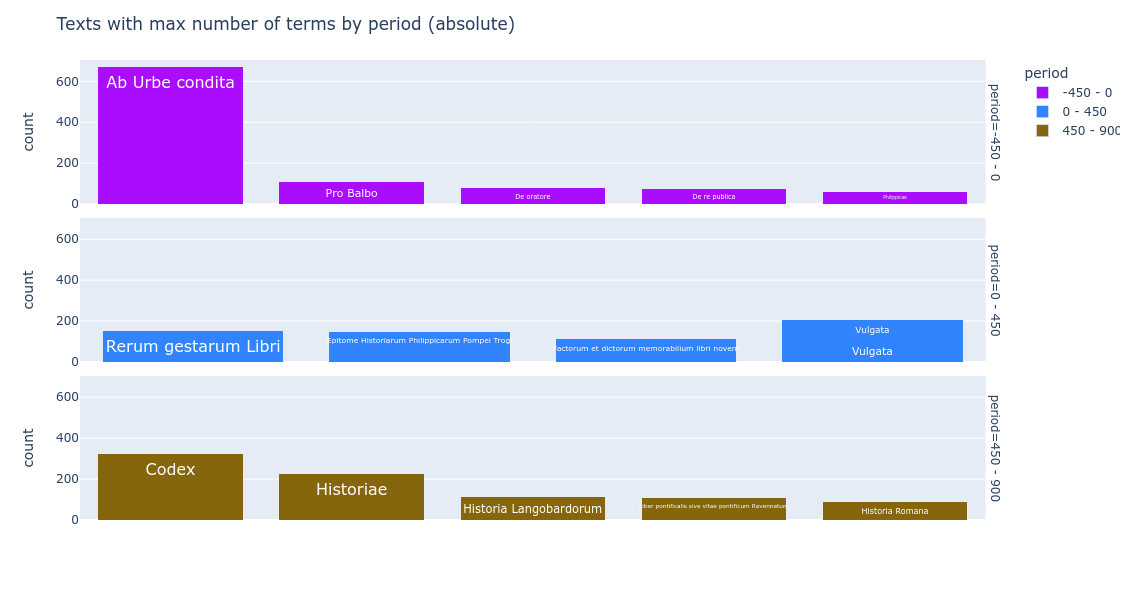

In [544]:
fig = px.bar(top_terms_by_title_sel,
                   x="title", y="count", color="period", color_discrete_map=periods2colors,
             category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=1200, hover_data=["creator", "title", "period"], barmode="stack", text="title", facet_row="period")
fig.update_xaxes(matches=None, visible=False)
fig.update_traces(textposition='inside', textfont_size=16)
fig.update_layout(title="Texts with max number of terms by period (absolute)",
                  uniformtext_minsize=12, height = 600, width=500)
fig.show()

### By author

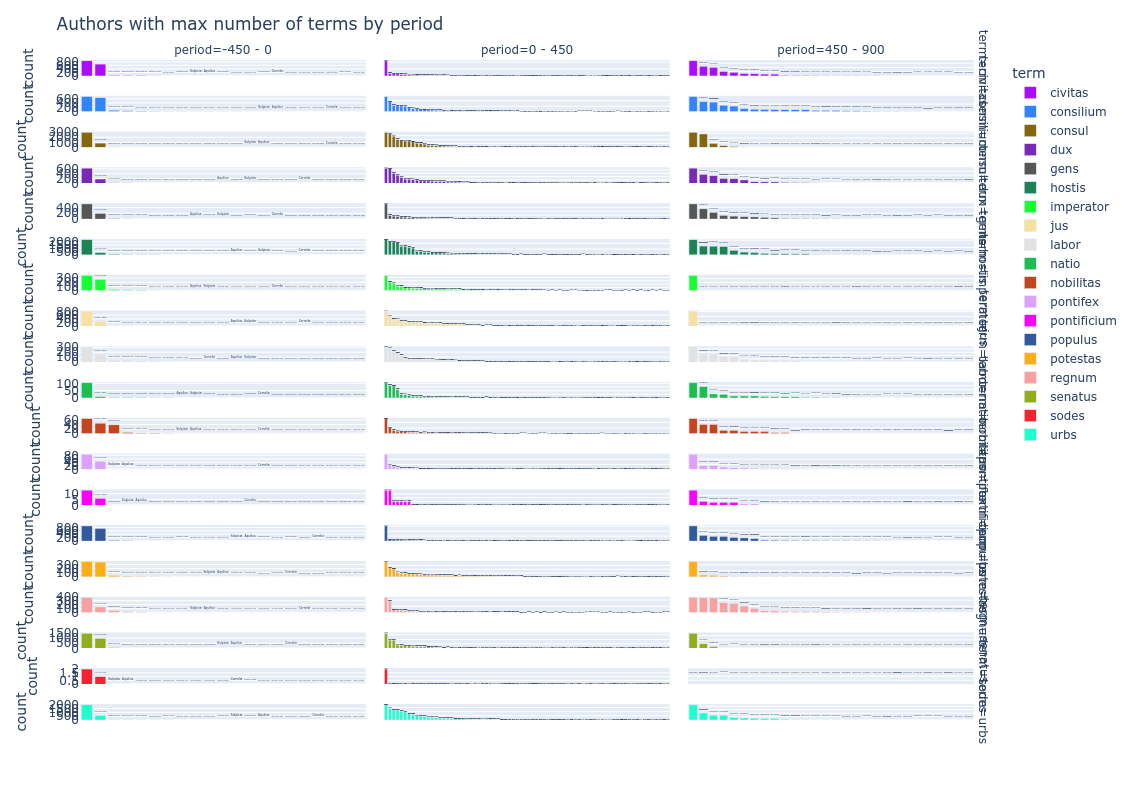

In [529]:
#top_terms_by_author
top_terms_by_author = terms_by_text.sort_values('count', ascending=False).groupby(["creator","term","period"], observed=True).agg({'count':np.sum}).reset_index().sort_values("count", ascending=False)
fig = px.bar(top_terms_by_author, x="creator", y="count", color="term", facet_col="period", facet_row="term", text="creator", facet_col_wrap=2, category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=800, hover_data=["creator", "period"], color_discrete_map=color_discrete_map_terms)

fig.update_layout(title="Authors with max number of terms by period", uniformtext_minsize=8)
fig.update_xaxes(matches=None, visible=False)
fig.update_traces(textposition='outside', textfont_size=14)
fig.update_yaxes(matches=None)
fig.show()

### By genre

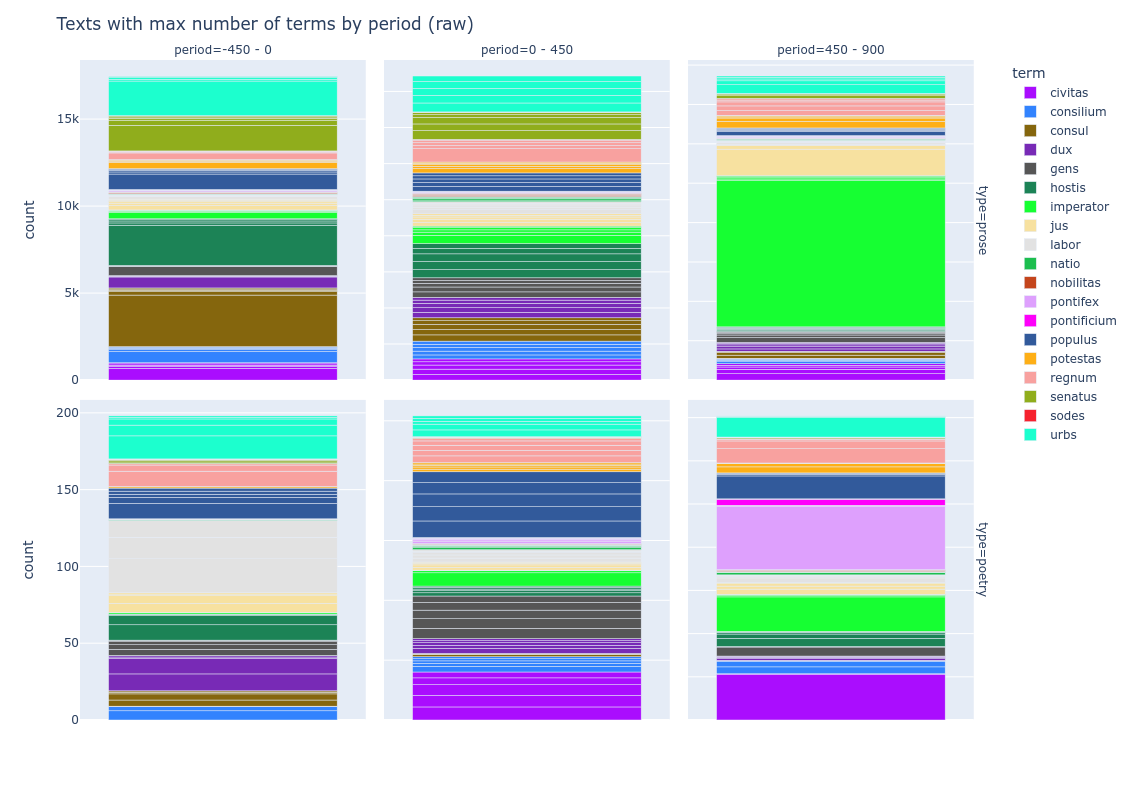

In [531]:
# terms by genre
top_terms_by_text.head()
top_terms_by_genre = terms_by_text.sort_values('count', ascending=False).groupby(["term", "type","period"]).head(5).sort_values("count", ascending=False)
top_terms_by_genre.head()
fig = px.bar(top_terms_by_genre,x="period", y="count", color="term", facet_col="period", facet_row="type", facet_col_wrap=2, 
             category_orders={"period":intervals_labels, "term": socio_political_terms}, 
             height=800, hover_data=["id", "creator", "title", "period"], color_discrete_map=color_discrete_map_terms)
fig.update_layout(title="Texts with max number of terms by period (raw)", uniformtext_minsize=8)
fig.update_xaxes(matches=None, visible=False)
fig.update_yaxes(matches=None)
fig.show()